In [5]:
import platform                  # Python 3.9.16
import sys

import numpy             as np   # Numpy 1.23.2
import pandas            as pd   # Pandas 2.0.3
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
    'font.size'     : 16,
    'axes.grid'     : True,
    'grid.linestyle': '--'
})

import statsmodels.api  as sm    # Statsmodels 0.14.0
#import tensorflow       as tf    # Tensor Flow 2.12.0
#import tensorflow.keras as keras # Keras 2.12.0

In [6]:
import statsmodels.datasets.co2 as co2

co2_raw = co2.load().data
df = co2_raw.iloc[353:] # 1965以降のデータを抽出
df = df.resample('M').mean() # 月次データに変換 (月の最終日を取得)"
df.index.name = "YEAR"
df

/tmp/ipykernel_10371/339486277.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').mean() # 月次データに変換 (月の最終日を取得)"


,co2
YEAR,
1965-01-31,319.400
1965-02-28,320.450
1965-03-31,320.925
1965-04-30,322.000
1965-05-31,322.060
...,...
2001-08-31,369.425
2001-09-30,367.880
2001-10-31,368.050


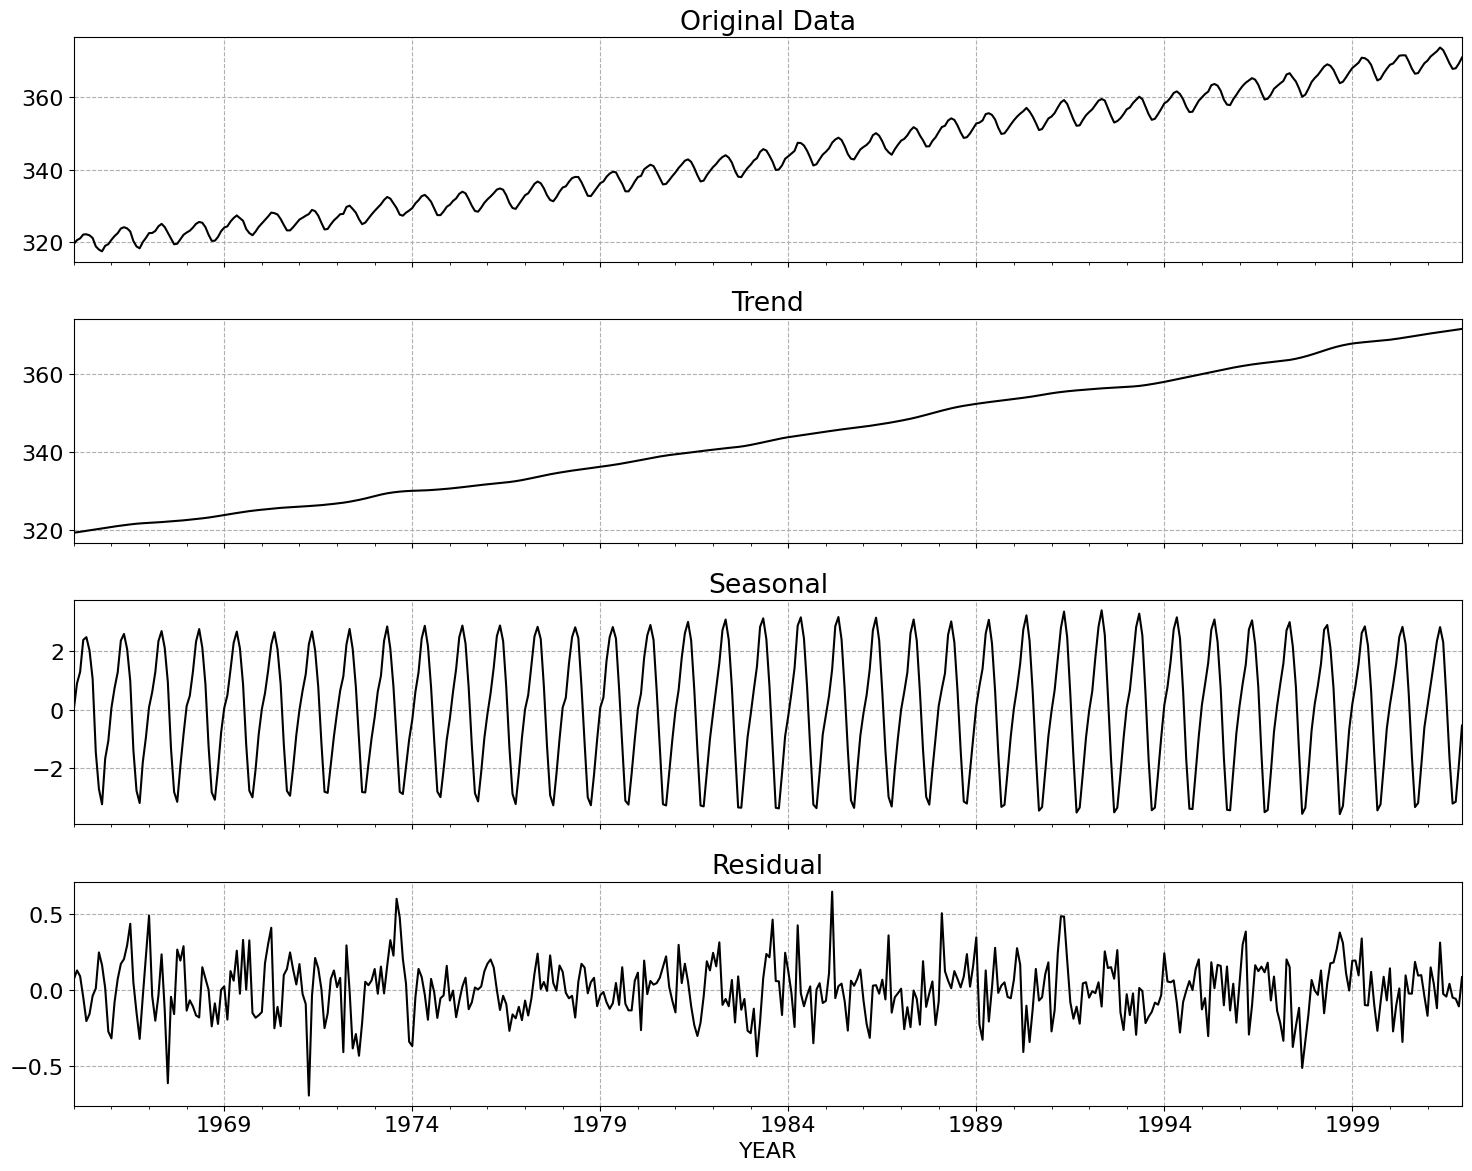

In [7]:
# STL分解
stl = sm.tsa.STL(df["co2"]).fit()

# それぞれの成分を描画
fig, ax = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

df["co2"].plot(ax=ax[0], c='black')
ax[0].set_title("Original Data")

stl.trend.plot(ax=ax[1], c='black')
ax[1].set_title("Trend")

stl.seasonal.plot(ax=ax[2], c='black')
ax[2].set_title("Seasonal")

stl.resid.plot(ax=ax[3], c='black')
ax[3].set_title("Residual")

plt.tight_layout()

plt.show()

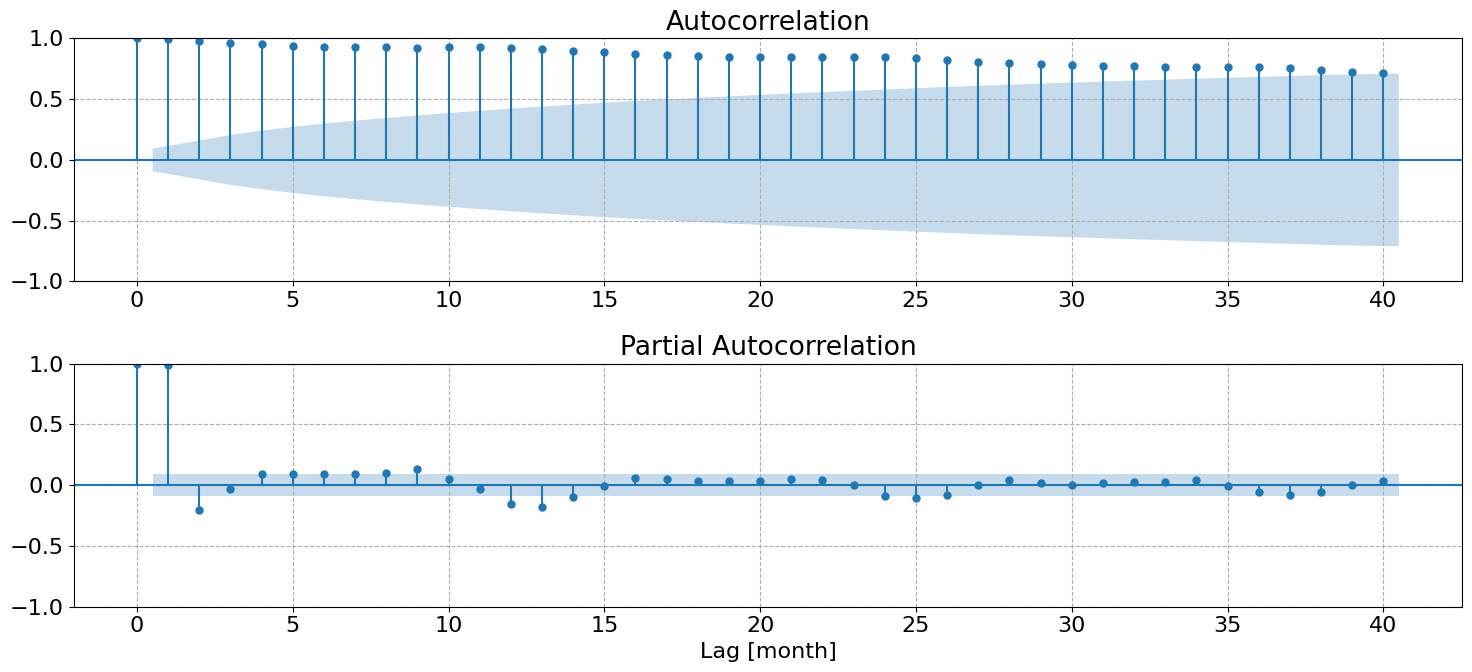

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# コレログラムを描画
fig, ax = plt.subplots(2, 1, figsize=(15,7))
plot_acf (df["co2"], lags=40, ax=ax[0]) # 自己相関係数
plot_pacf(df["co2"], lags=40, ax=ax[1]) # 偏自己相関係数
plt.xlabel('Lag [month]')
plt.tight_layout()
plt.show()

In [10]:
min_val, max_val = np.min(df["co2"].values), np.max(df["co2"].values)
scale = max_val - min_val
df["y"] = (df["co2"].values - min_val) / scale #正規化

display(df)

,co2,y
YEAR,,
1965-01-31,319.400,0.036486
1965-02-28,320.450,0.055083
1965-03-31,320.925,0.063496
1965-04-30,322.000,0.082536
1965-05-31,322.060,0.083599
...,...,...
2001-08-31,369.425,0.922512
2001-09-30,367.880,0.895147
2001-10-31,368.050,0.898158


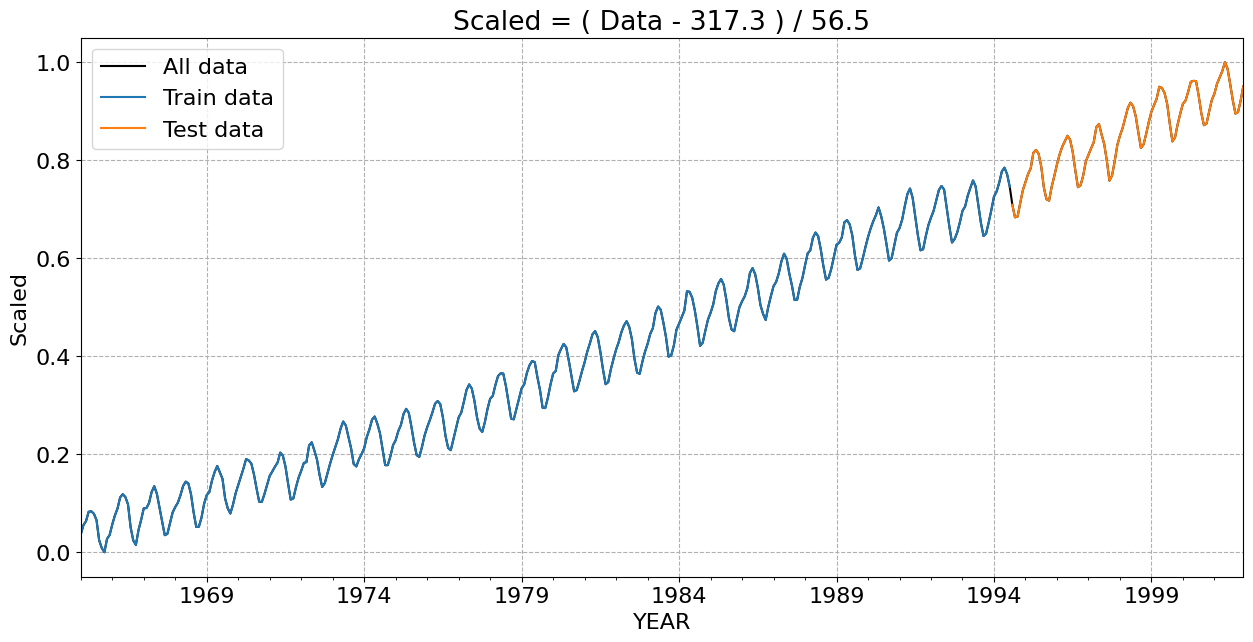

In [11]:
ratio = 0.8 #学習用データの割合（80%）
train_size = int(ratio * len(df)) #前半(学習用) と 後半(試験用)に分ける
test_size  = len(df) - train_size #試験用データのサイズ

train = df.iloc[:train_size] #全データから前半を抜粋
test  = df.iloc[train_size:] #後半を抜粋

# 正規化されたCO2濃度の推移を図示して確認する
fig = plt.subplots(figsize=(15, 7))
df["y"]   .plot(label='All data',   color='black')
train["y"].plot(label='Train data', color='C0')
test["y"] .plot(label='Test data',  color='C1')
plt.ylabel("Scaled")
plt.title(f"Scaled = ( Data - {min_val:.1f} ) / {scale:.1f}")
plt.legend()

plt.show()

In [12]:
def my_get_rmse(pred: pd.Series, true: pd.Series) -> pd.Series:
    """真値と予測値のRMSEを計算する関数
    Args:
        pred: 予測値
        true: 真値
    Returns:
        rmses: RMSEのリスト
    """
    y_pred = pred.values.reshape(-1, 1)
    y_true = true.values.reshape(-1, 1)
    y_error = y_true - y_pred
    rmses = np.sqrt(np.mean(y_error**2, axis=1))

    return pd.Series(rmses, index=pred.index)

In [13]:
def my_plot_results(pred_test: pd.Series) -> plt.figure:
    """真値と予測値の比較をプロットする関数
    Args:
        pred_test: 試験用データの予測
    Returns:
        fig: Figure object.
        ax: Axes object (左列, 元データ).
        bx: Axes object (右列, RMSE).
    """

    # STL分解
    stl_true = sm.tsa.STL(test["co2"]).fit()
    stl_test = sm.tsa.STL(pred_test)  .fit()

    # それぞれの成分を描画
    fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
    ax,  bx   = axes.transpose()[0], axes.transpose()[1]

    for i in range(4):
        ax[i].set_ylabel(["Original Data", "Trend", "Seasonal\n", "Residual"][i])

    # 元データ
    ax[0].set_title("ax[0].set_title(name)")
    test["co2"]      .plot(ax=ax[0], c='black', label='Original Data')
    pred_test        .plot(ax=ax[0], c='C1'   , label='Prediction')

    stl_true.trend   .plot(ax=ax[1], c='black')
    stl_test.trend   .plot(ax=ax[1], c='C1')

    stl_true.seasonal.plot(ax=ax[2], c='black')
    stl_test.seasonal.plot(ax=ax[2], c='C1')

    stl_true.resid   .plot(ax=ax[3], c='black')
    stl_test.resid   .plot(ax=ax[3], c='C1')

    # RMSE
    rmse_original = my_get_rmse(pred_test,         test["co2"])
    rmse_trend    = my_get_rmse(stl_test.trend,    stl_true.trend)
    rmse_seasonal = my_get_rmse(stl_test.seasonal, stl_true.seasonal)
    rmse_resid    = my_get_rmse(stl_test.resid,    stl_true.resid)

    bx[0].set_title("bx[0].set_title(name)")
    rmse_original.plot(ax=bx[0], c='C1')
    rmse_trend   .plot(ax=bx[1], c='C1')
    rmse_seasonal.plot(ax=bx[2], c='C1')
    rmse_resid   .plot(ax=bx[3], c='C1')

    ax[0].legend()
    plt.tight_layout()

    return fig, ax, bx

# 自己回帰モデル (Auto Regressive Model, AR)

/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57095D+03    |proj g|=  4.13245D+05

At iterate    5    f= -1.11034D+00    |proj g|=  1.48919D+00

At iterate   10    f= -1.85442D+00    |proj g|=  2.04656D+00

At iterate   15    f= -2.40098D+00    |proj g|=  1.30952D+01

At iterate   20    f= -2.64070D+00    |proj g|=  3.80239D+00

At iterate   25    f= -2.65332D+00    |proj g|=  2.63958D-01

At iterate   30    f= -2.65783D+00    |proj g|=  2.62233D-01

At iterate   35    f= -2.80900D+00    |proj g|=  2.04067D+01

At iterate   40    f= -2.84717D+00    |proj g|=  8.03382D+00

At iterate   45    f= -2.86202D+00    |proj g|=  1.65665D-01

At iterate   50    f= -2.88015D+00    |proj g|=  1.86637D+00

At iterate   55    f= -2.90563D+00    |proj g|=  2.40361D+00

At iterate   60    f= -3.00134D+00    |proj g|=  4.14415D-01

At iterate   65    f= -3.0

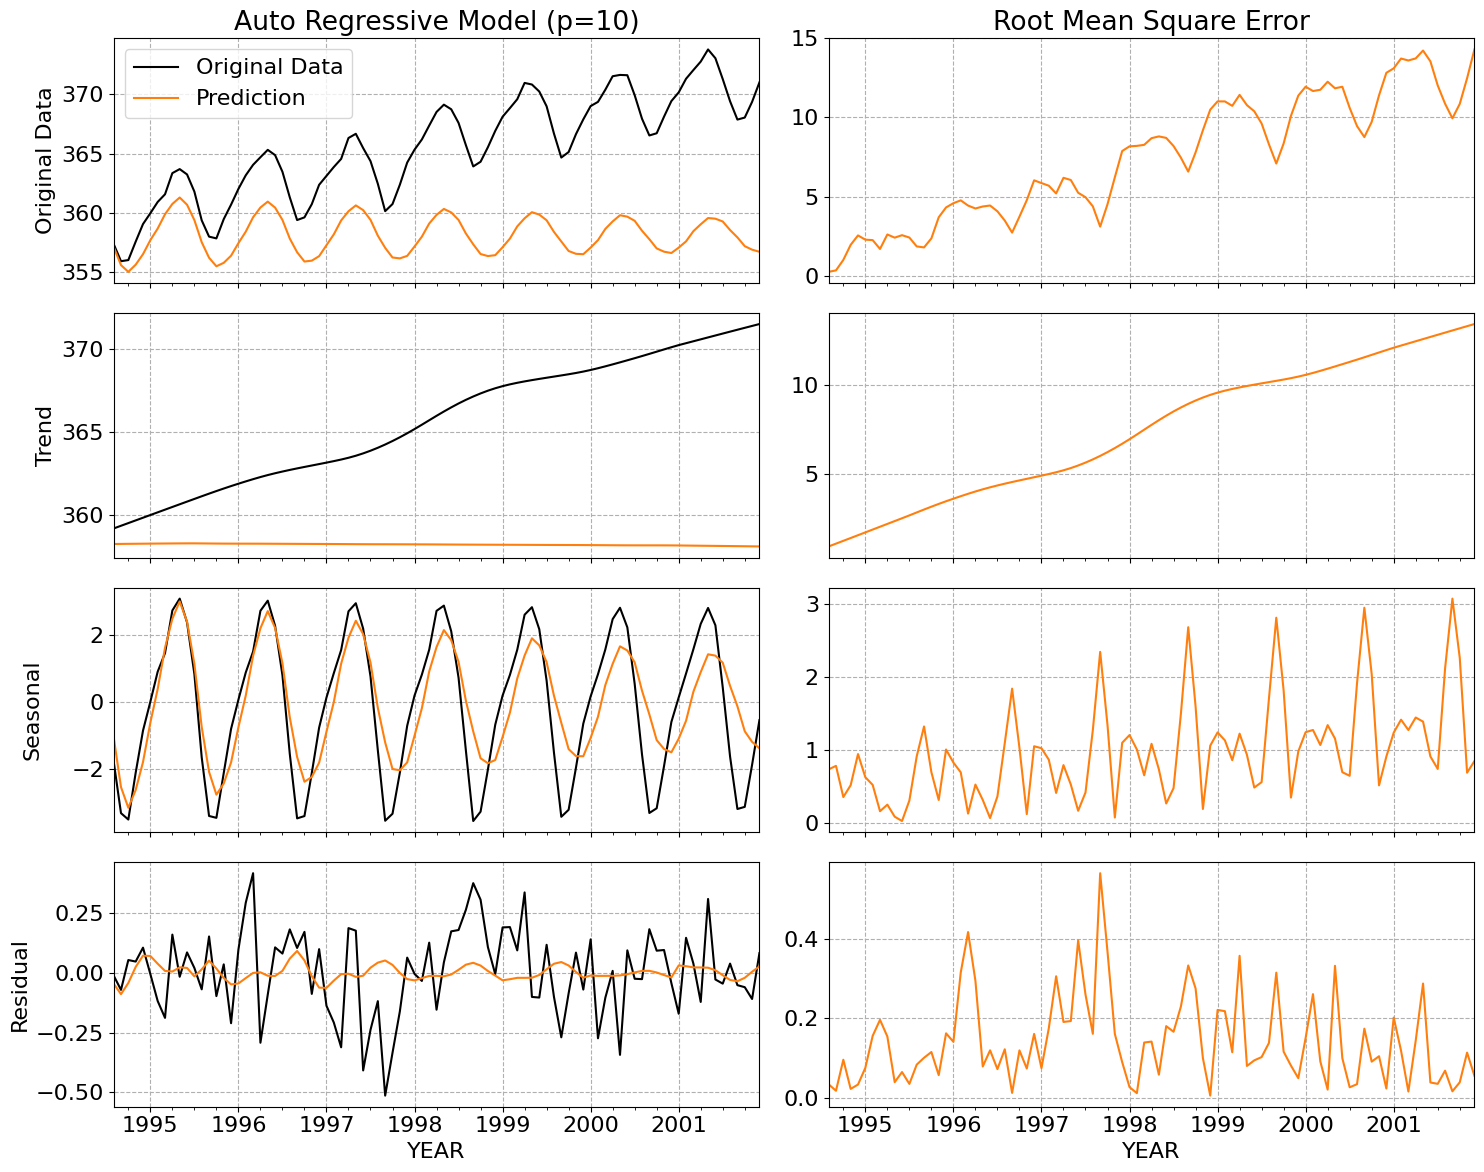

In [14]:
p = 10

ar = sm.tsa.SARIMAX(train["y"].values,
                    order=(p, 0, 0)
                    ).fit(maxiter=1000)

pred_val = ar.forecast(test_size)

pred_test = pd.Series(pred_val * scale + min_val, 
                      index=test.index)

fig, ax, bx = my_plot_results(pred_test)

ax[0].set_title(f"Auto Regressive Model (p={p})")
bx[0].set_title("Root Mean Square Error")
plt.show()

# 移動平均モデル (Moving Average Model, MA)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02817D-01    |proj g|=  1.89144D+00
  ys=-1.541E-02  -gs= 4.450E-01 BFGS update SKIPPED

At iterate    5    f= -1.01470D+00    |proj g|=  2.74509D+00


 This problem is unconstrained.



At iterate   10    f= -2.23349D+00    |proj g|=  3.08868D+00

At iterate   15    f= -2.24581D+00    |proj g|=  1.68427D-01

At iterate   20    f= -2.24647D+00    |proj g|=  1.03264D+00

At iterate   25    f= -2.25132D+00    |proj g|=  1.13694D-01

At iterate   30    f= -2.25199D+00    |proj g|=  2.68684D-01

At iterate   35    f= -2.25280D+00    |proj g|=  2.48686D-02

At iterate   40    f= -2.25445D+00    |proj g|=  3.93896D-02

At iterate   45    f= -2.25496D+00    |proj g|=  7.35742D-02

At iterate   50    f= -2.25509D+00    |proj g|=  3.10887D-02

At iterate   55    f= -2.25510D+00    |proj g|=  3.87004D-02

At iterate   60    f= -2.25519D+00    |proj g|=  2.16439D-02

At iterate   65    f= -2.25529D+00    |proj g|=  5.98218D-02

At iterate   70    f= -2.25531D+00    |proj g|=  6.22543D-03

At iterate   75    f= -2.25535D+00    |proj g|=  2.26925D-02

At iterate   80    f= -2.25535D+00    |proj g|=  2.71916D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


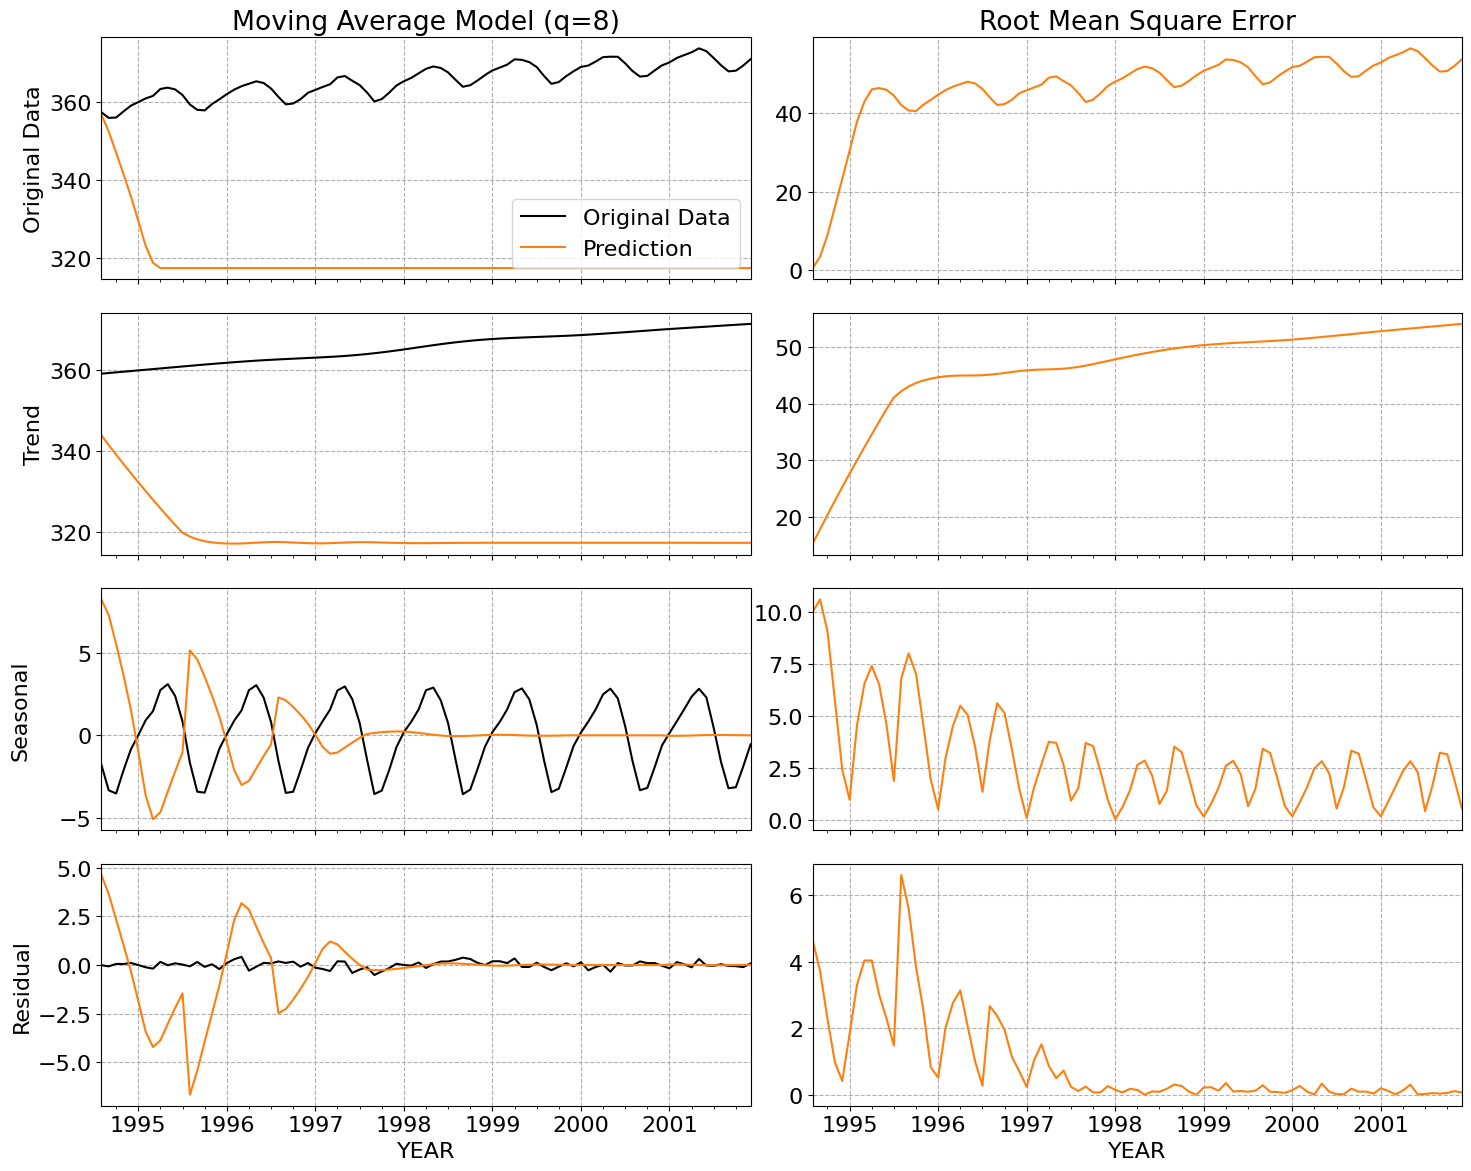

In [15]:
q = 8

ma = sm.tsa.SARIMAX(train["y"].values,
                    order=(0, 0, q)
                    ).fit(maxiter=1000)

pred_val = ma.forecast(test_size)

pred_test = pd.Series(pred_val * scale + min_val, 
                      index=test.index)

fig, ax, bx = my_plot_results(pred_test)

ax[0].set_title(f"Moving Average Model (q={q})")
bx[0].set_title("Root Mean Square Error")
plt.show()

# 自己回帰移動平均モデル (ARMA)

/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81420D+03    |proj g|=  5.96461D+05

At iterate    5    f= -7.95601D-01    |proj g|=  5.59269D+00

At iterate   10    f= -2.06275D+00    |proj g|=  1.94355D+01

At iterate   15    f= -2.62929D+00    |proj g|=  2.10197D+01

At iterate   20    f= -2.69604D+00    |proj g|=  5.64886D-01

At iterate   25    f= -2.70013D+00    |proj g|=  3.97473D+00

At iterate   30    f= -2.77775D+00    |proj g|=  2.16993D+00

At iterate   35    f= -2.89332D+00    |proj g|=  1.78643D+00

At iterate   40    f= -2.91656D+00    |proj g|=  2.02738D-01

At iterate   45    f= -2.98526D+00    |proj g|=  8.60702D-01

At iterate   50    f= -2.99469D+00    |proj g|=  2.69345D+00

At iterate   55    f= -3.06619D+00    |proj g|=  2.51529D+00

At iterate   60    f= -3.10907D+00    |proj g|=  8.39870D-01

At iterate   65    f= -3.1

/home/bitwalk/MyProjects/stock-explorer/venv/lib64/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


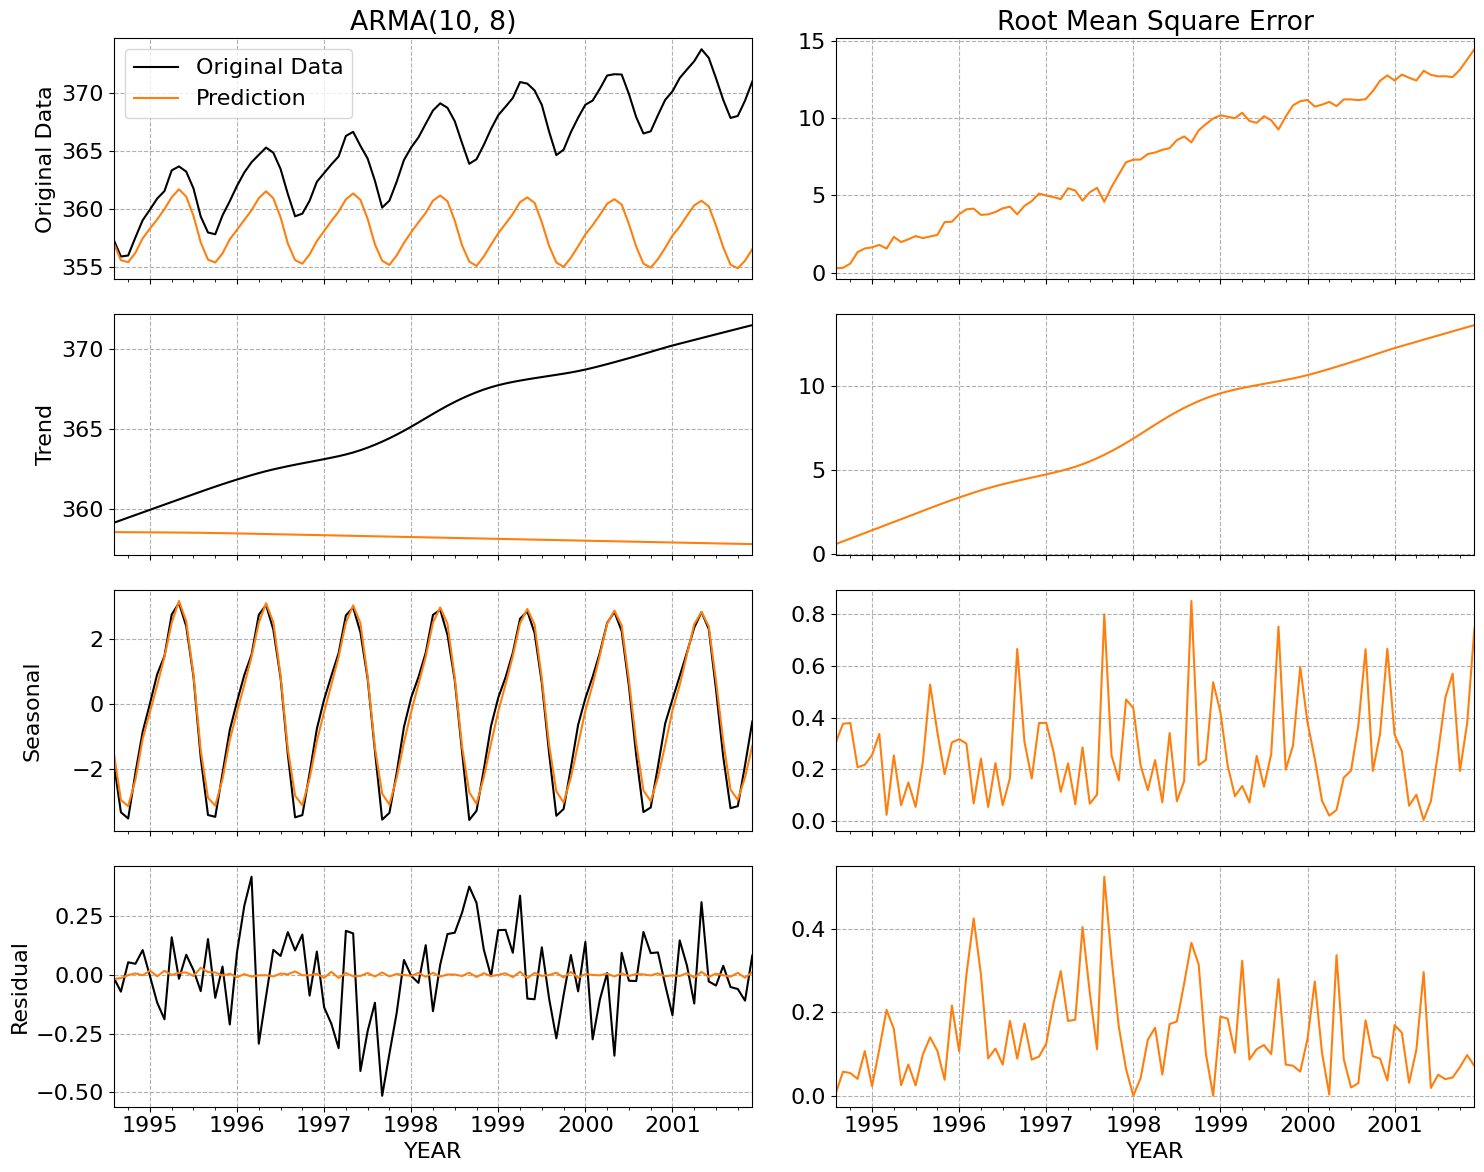

In [16]:
p, q = 10, 8

arma = sm.tsa.SARIMAX(train["y"].values,
                      order=(p, 0, q)
                      ).fit(maxiter=1000)

pred_val = arma.forecast(test_size)

pred_test = pd.Series(pred_val * scale + min_val, 
                      index=test.index)

fig, ax, bx = my_plot_results(pred_test)

ax[0].set_title(f"ARMA{(p, q)}")
bx[0].set_title("Root Mean Square Error")
plt.show()

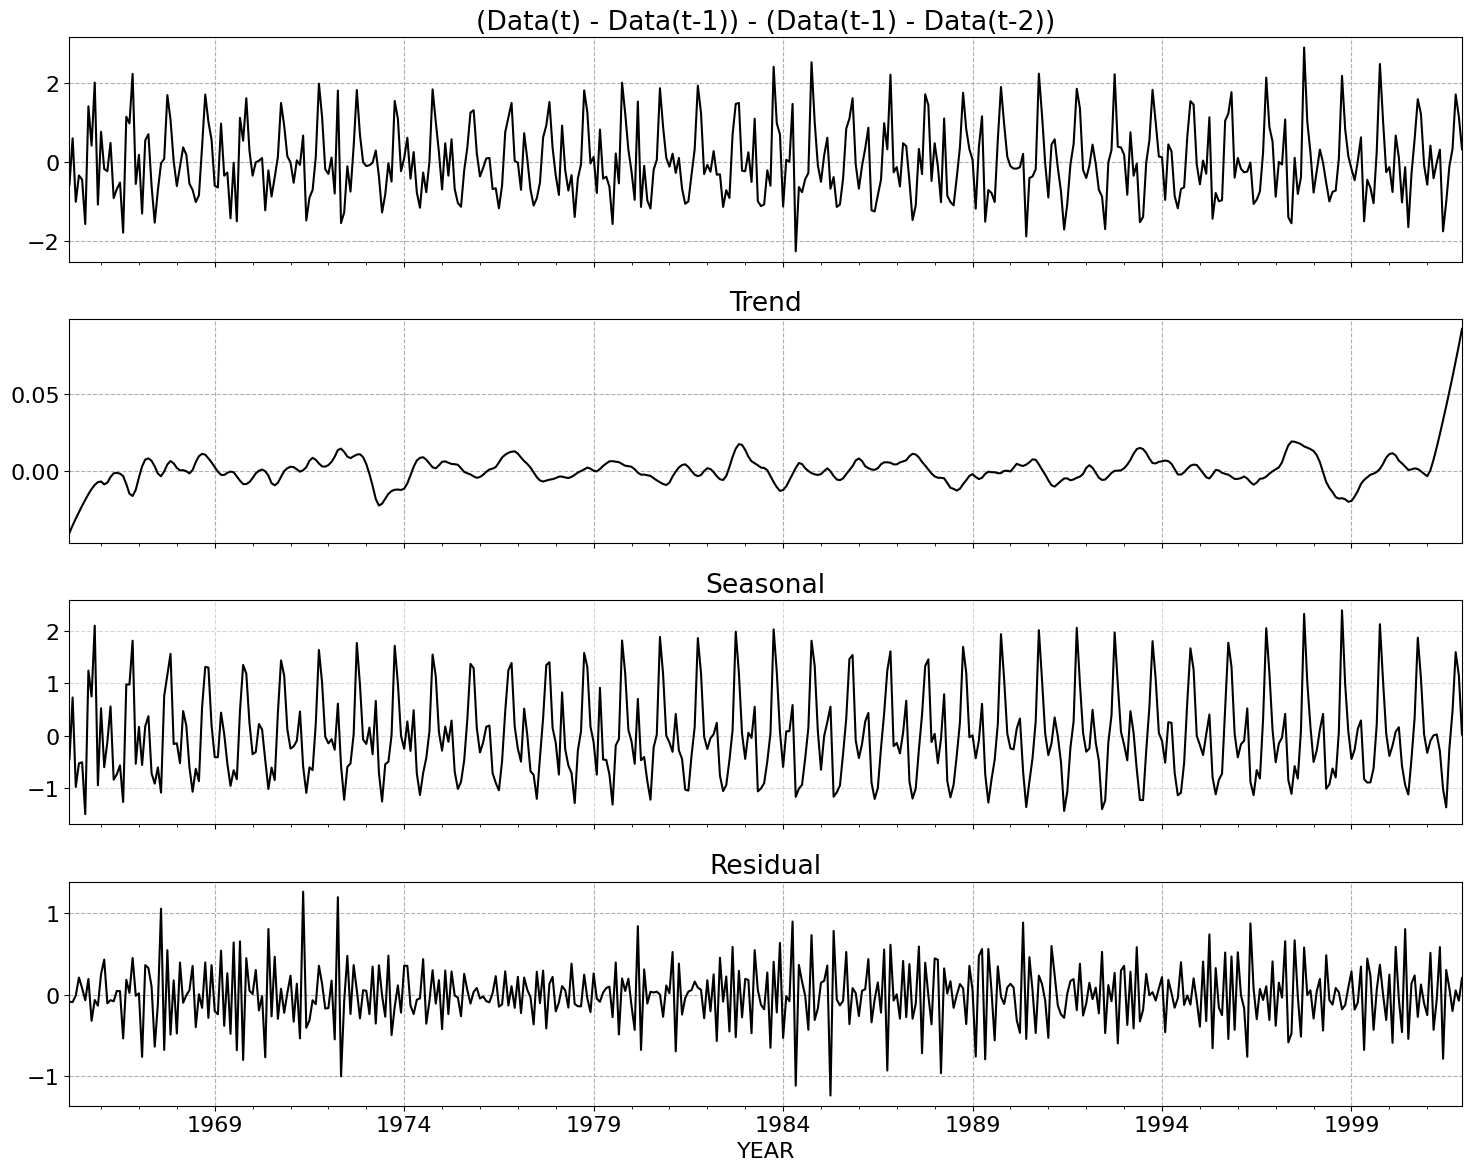

In [17]:
from statsmodels.tsa.seasonal import STL

diff1 = df["co2"].diff().dropna()
diff2 = diff1    .diff().dropna()

# STL分解
stl = STL(diff2).fit()

# それぞれの成分を描画
fig, ax = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

diff2.plot(ax=ax[0], c='black')
ax[0].set_title("(Data(t) - Data(t-1)) - (Data(t-1) - Data(t-2))")

stl.trend.plot(ax=ax[1], c='black')
ax[1].set_title("Trend")

stl.seasonal.plot(ax=ax[2], c='black')
ax[2].grid(True, linestyle='--', alpha=0.5)
ax[2].set_title("Seasonal")

stl.resid.plot(ax=ax[3], c='black')
ax[3].set_title("Residual")

plt.tight_layout()

plt.show()

# 自己回帰和分移動平均モデル (ARIMA)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.52582D+00    |proj g|=  4.59869D+01

At iterate    5    f= -3.54249D+00    |proj g|=  1.35614D+00



 This problem is unconstrained.


At iterate   10    f= -3.54890D+00    |proj g|=  2.71496D+00

At iterate   15    f= -3.56445D+00    |proj g|=  3.00709D+01

At iterate   20    f= -3.58029D+00    |proj g|=  6.85111D-01

At iterate   25    f= -3.59310D+00    |proj g|=  1.72625D+01

At iterate   30    f= -3.61582D+00    |proj g|=  3.50721D+00

At iterate   35    f= -3.61760D+00    |proj g|=  5.24634D+00

At iterate   40    f= -3.63767D+00    |proj g|=  2.56076D+00

At iterate   45    f= -3.63808D+00    |proj g|=  4.08997D-01

At iterate   50    f= -3.63924D+00    |proj g|=  5.22080D+00

At iterate   55    f= -3.64358D+00    |proj g|=  4.46506D-01

At iterate   60    f= -3.65314D+00    |proj g|=  6.42022D+00

At iterate   65    f= -3.65411D+00    |proj g|=  3.34314D-01

At iterate   70    f= -3.65414D+00    |proj g|=  3.42611D-01

At iterate   75    f= -3.65487D+00    |proj g|=  3.06500D+00

At iterate   80    f= -3.65625D+00    |proj g|=  3.01600D+00

At iterate   85    f= -3.65708D+00    |proj g|=  1.29236D+00

At itera


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  165    f= -3.65965D+00    |proj g|=  2.81499D-02

At iterate  170    f= -3.65988D+00    |proj g|=  7.06528D-01

At iterate  175    f= -3.66030D+00    |proj g|=  1.53096D-01

At iterate  180    f= -3.66031D+00    |proj g|=  9.35470D-02

At iterate  185    f= -3.66038D+00    |proj g|=  2.26408D-02

At iterate  190    f= -3.66041D+00    |proj g|=  5.97703D-01

At iterate  195    f= -3.66065D+00    |proj g|=  4.91924D-01

At iterate  200    f= -3.66077D+00    |proj g|=  1.35072D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17    204    282      2     0     0   1.495D-01  -3.661D+00
  F =  -3.66077613021

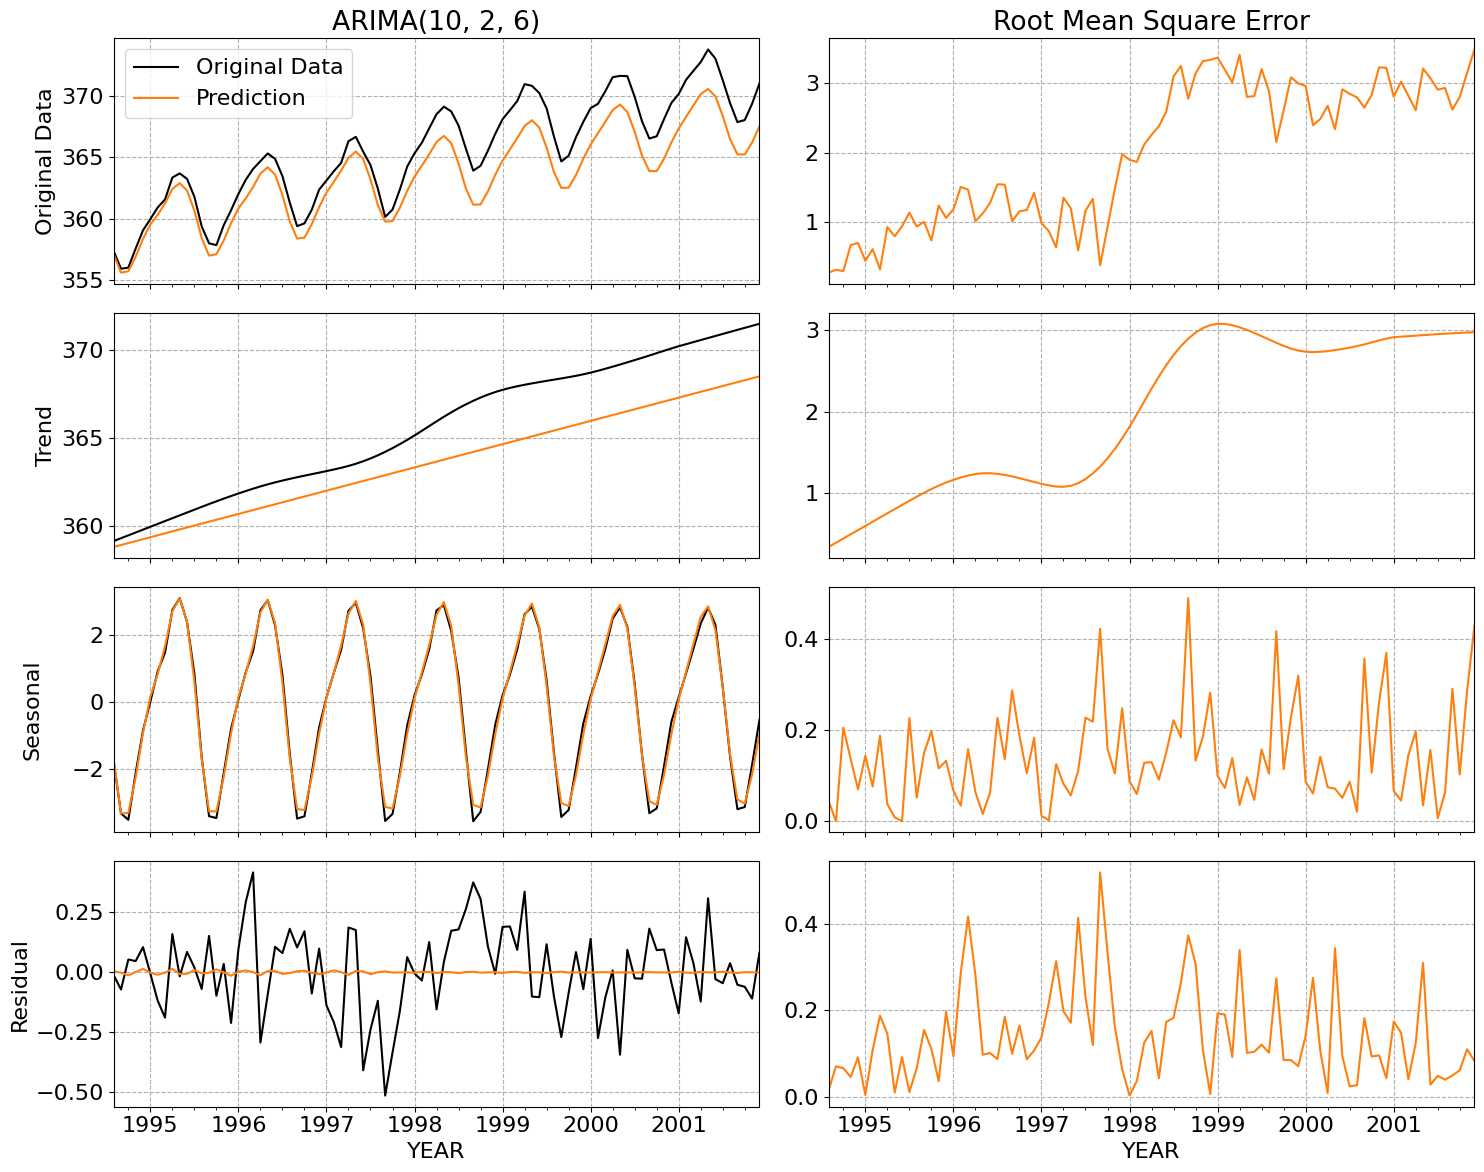

In [18]:
p, d, q = 10, 2, 6

arima = sm.tsa.SARIMAX(train["y"].values,
                       order=(p, d, q)
                       ).fit(maxiter=1000)

pred_val = arima.forecast(test_size)

pred_test = pd.Series(pred_val * scale + min_val, 
                      index=test.index)

fig, ax, bx = my_plot_results(pred_test)

ax[0].set_title(f"ARIMA{(p, d, q)}")
bx[0].set_title("Root Mean Square Error")
plt.show()

# Seasonal ARIMAモデル (SARIMA)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.61285D+00    |proj g|=  5.18740D+00

At iterate    5    f= -3.61329D+00    |proj g|=  2.92421D+00

At iterate   10    f= -3.61909D+00    |proj g|=  5.01425D+00

At iterate   15    f= -3.61962D+00    |proj g|=  3.94412D+00

At iterate   20    f= -3.63234D+00    |proj g|=  1.63690D+01

At iterate   25    f= -3.63600D+00    |proj g|=  2.23671D-01

At iterate   30    f= -3.64269D+00    |proj g|=  1.46894D+01

At iterate   35    f= -3.65851D+00    |proj g|=  3.22344D-01

At iterate   40    f= -3.66816D+00    |proj g|=  3.42823D+00

At iterate   45    f= -3.66856D+00    |proj g|=  2.32131D+00

At iterate   50    f= -3.67185D+00    |proj g|=  3.87214D+00

At iterate   55    f= -3.67990D+00    |proj g|=  9.03399D-01

At iterate   60    f= -3.68020D+00    |proj g|=  9.84659D-01

At iterate   65    f= -3.6

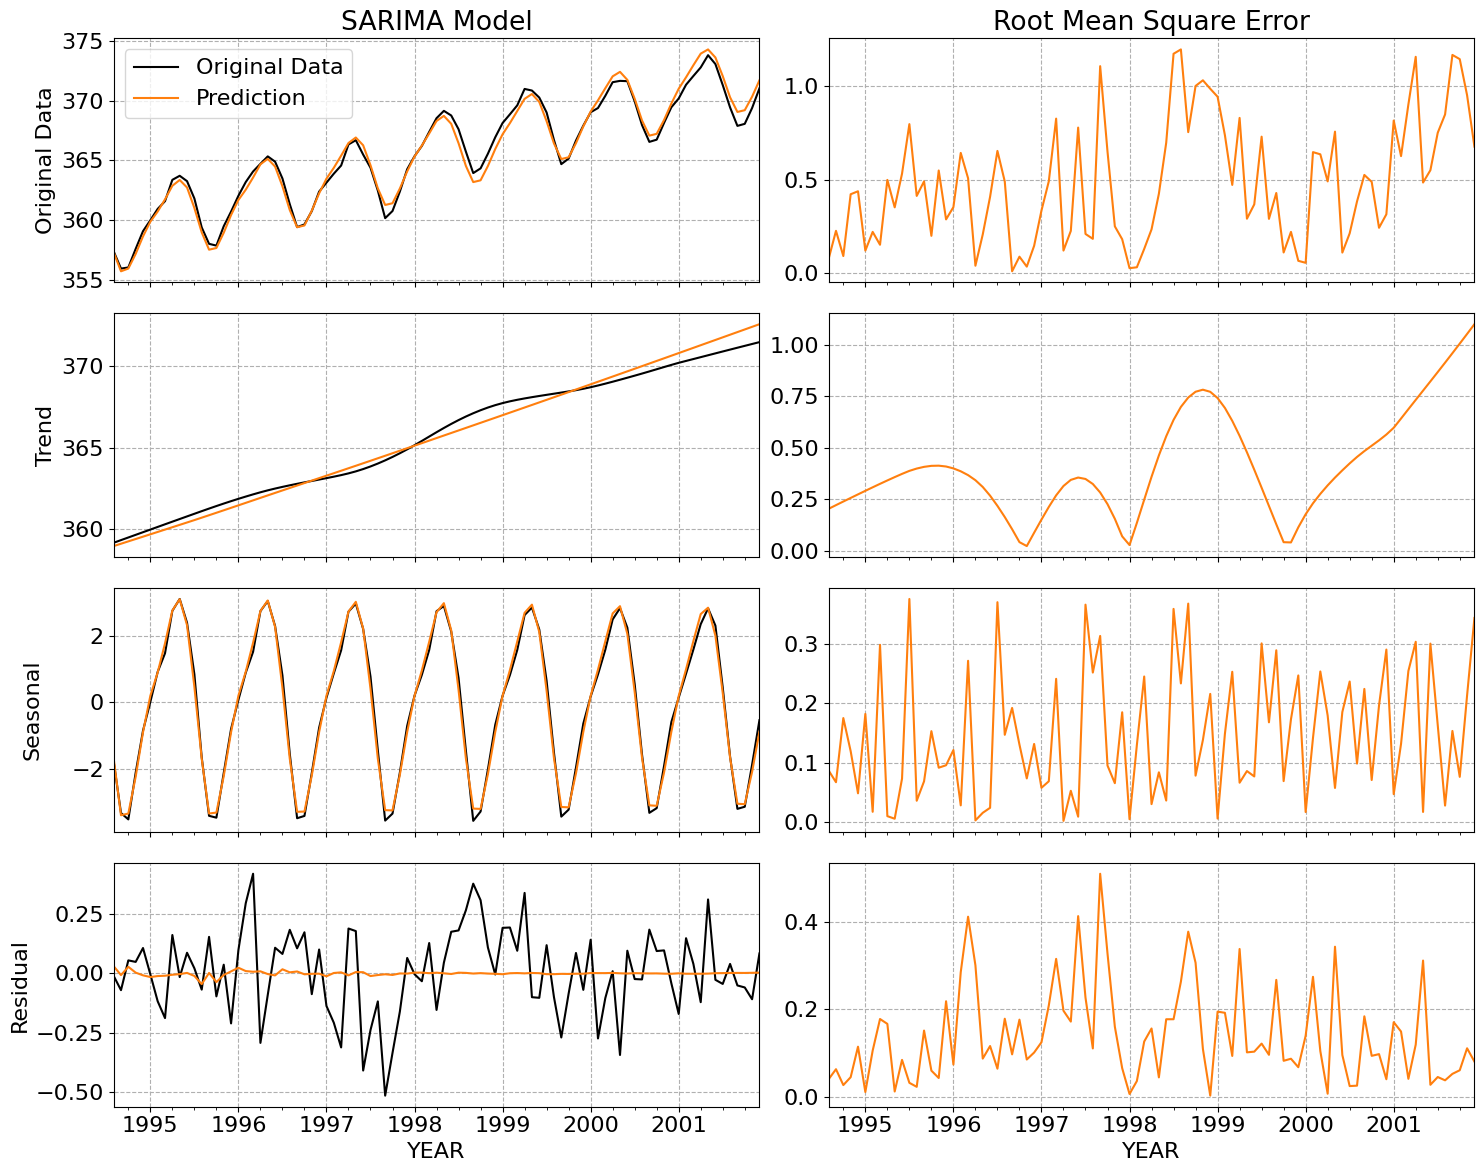

In [19]:
p,  d,  q  = 10, 2, 8
ps, ds, qs =  2, 0, 2
s = 12 # 季節性変動の周期

sarima = sm.tsa.SARIMAX(train["y"].values,
                        order=(p, d, q),
                        seasonal_order=(ps, ds, qs, s)
                        ).fit(maxiter=1000)

pred_val = sarima.forecast(test_size)

pred_test = pd.Series(pred_val * scale + min_val, 
                      index=test.index)

fig, ax, bx = my_plot_results(pred_test)

ax[0].set_title("SARIMA Model")
bx[0].set_title("Root Mean Square Error")
plt.show()